In [2]:
import pandas as pd
import numpy as np
import re
import math

import requests, json
import pandas as pd

YEAR_LIST = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]



def jsonToDataFrame(YEAR_LIST):
    temp = {}
    year_list = []
    name = []
    birth = []
    registered = []
    fullTime = []
    responsibilities = []
    career = []
    stock = []
    time1 = []
    time2 = []
    position = []

    for year in YEAR_LIST:
        with open(f"./{year}.json", 'r') as f:
            json_data = json.load(f)
            for i in range(len(json_data['results'])):
                properties = json_data['results'][i]['properties']
                year_list.append(year)
                for key in properties:
                    if key == '이름':
                        name.append(properties[key]['title'][0]['text']['content'])
                    elif key == '출생년월':
                        birth.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '등기임원 여부':
                        registered.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '상근 여부':
                        fullTime.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '담당업무':
                        responsibilities.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '주요경력':
                        career.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '의결권 있는 주식수':
                        stock.append(properties[key]['number'])
                    elif key == '재직기간':
                        time1.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '임기만료일':
                        time2.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '직위':
                        position.append(properties[key]['rich_text'][0]['text']['content'])

    temp['이름'] = name
    temp['연도'] = year_list
    temp['출생년월'] = birth
    temp['등기임원 여부'] = registered
    temp['상근 여부'] = fullTime
    temp['담당업무'] = responsibilities
    temp['주요경력'] = career
    temp['의결권 있는 주식수'] = stock
    temp['재직기간'] = time1
    temp['임기만료일'] = time2
    temp['직위'] = position
    return temp

dict = jsonToDataFrame(YEAR_LIST)

df = pd.DataFrame.from_dict(data=dict, orient='columns')

In [3]:
df['의결권 있는 주식수'].fillna(0.0, inplace=True)
#'\xa0' 처리
df['주요경력']=df['주요경력'].str.replace('\xa0', '')
#대학, 전공 피처 생성
temp=df['주요경력'].str.split('\n')
colleges=temp.str.get(0)

#추가로 처리해줘야될 대학 form 맞춰주기
colleges[colleges== 'University of Bath 사회과학대학원(석사)'] ='UniversityofBath 사회과학대학원(석사)'
colleges[colleges== 'Florida International University 경영대학원(박사)']='FloridaInternationalUniversity 경영대학원(박사)'
colleges[colleges== 'Ohio State University 정책대학원(박사)'] = 'OhioStateUniversity 정책대학원(박사)'
colleges[colleges== 'KDI국제정책대학원(석사)'] = 'KDI 국제정책대학원(석사)'
colleges[colleges== '상명여자사범대'] = '상명여자사범대 교육학'
colleges[colleges== '한국외국어대경영학(석사)'] = '한국외국어대 경영학(석사)'
colleges[colleges== '미시간대학교 경영대학원 MBA'] = '미시간대학교 경영대학원MBA'

#대학, 전공으로 나누기
ttemp = colleges.str.split() 

#대학 피처 생성
df['대학교']=ttemp.str.get(0)

#전공 피처 생성
tttemp = ttemp.str.get(1)
tttemp=tttemp.replace(r'\([^)]*\)', '', regex=True)
df['전공']=tttemp

#근속연수 생성
def create_work_years(x):
  temp = re.split(r'~|~\n', x)
  temp[0] = temp[0].strip()
  temp[1] = temp[1].strip()
  return int(temp[1][:4]) - int(temp[0][:4])

df['근속연수'] = df['재직기간'].apply(lambda x : create_work_years(x))

#주요경력 전처리
def replace_career(x):
  temp = [string.split() for string in re.split(r'\n |\n', x)]
  if len(temp)==1 :
    return {'대신증권'}
  else:
    return set(list(zip(*temp[1:]))[0])

df['주요경력요약'] = df['주요경력'].apply(lambda x : replace_career(x))

In [4]:
df_2014 = df[df['연도']==2014].reset_index(drop=True)
df_2015 = df[df['연도']==2015].reset_index(drop=True)
df_2016 = df[df['연도']==2016].reset_index(drop=True)
df_2017 = df[df['연도']==2017].reset_index(drop=True)
df_2018 = df[df['연도']==2018].reset_index(drop=True)
df_2019 = df[df['연도']==2019].reset_index(drop=True)
df_2020 = df[df['연도']==2020].reset_index(drop=True)
df_2021 = df[df['연도']==2021].reset_index(drop=True)
df_2022 = df[df['연도']==2022].reset_index(drop=True)
df_2023 = df[df['연도']==2023].reset_index(drop=True)

In [5]:
#학교 거리 계산
def cal_college(df1, df2, alpha = 0.7):
  #지역별로 나눔
  college_dict = {'서울경기':['상명여자사범대', '서울대', '홍익대', '성균관대', '연세대', '연세대학교', '동국대', '중앙대', '한국외대', '한국외국어대', '세종대학교', '세종대', '성균관대학교', '경희대', '서강대', '고려대', '건국대', '가천대', '가천대학교', '한양대', '명지대'],
                   '광역시':['부경대', '경북대', '전남대', '조선대', '한국과학기술원', '가천대', '인하대', '동아대', '대전대', '울산대', '영남공업전문대'],
                   '그외한국':['전북대', '원광대', '충북대', '충북대학교', '강원대', 'KDI'],
                   '해외':['FloridaInternationalUniversity', 'OhioStateUniversity', 'UniversityofBath', '조지아공대', 'Brown대', '카네기멜론대', '미시간대학교']}

  #키값 찾기
  for key, val in college_dict.items() :
    if df1['대학교'] in val :
      df1_key = key
    if df2['대학교'] in val :
      df2_key = key
          
  #k값 구하기
  if df1['대학교'] == df2['대학교'] :
    k=0
  elif df1_key == df2_key :
    k=1
  elif df1_key != df2_key :
    k=2

  return alpha ** k

#학과 거리 계산
def cal_department(df1, df2, alpha = 0.7):
  department_dict={'경영경제':['회계학', '세무학', '경제학', '국제경영학', '경영학', '무역학', 'MBA', '경제통상학', '경영대학원', '경영대학원MBA', '산업정보학', '금융공학', '국제금융학'],
                   '사회과학':['사회학', '사회과학대학원', '행정학', '정치외교학', '정치학', '신문방송학'],
                   '법률':['법학', '사법학', '정책대학원', '국제정책대학원'],
                   '인문':['불어불문학'],
                   '기타':['교육학', '인적자원개발학'],
                   '자연':['응용통계학', '통계학', '수학'],
                   '공학':['기계공학', '화학공학', '전자계산학', '전자전산학', '전산학', '항공우주학']}

  #키값 찾기
  for key, val in department_dict.items() :
    if df1['전공'] in val :
      df1_key = key
    if df2['전공'] in val :
      df2_key = key
          
  #k값 구하기
  if df1['전공'] == df2['전공'] :
    k=0
  elif df1_key == df2_key :
    k=1
  elif df1_key != df2_key :
    k=2

  return alpha ** k

#직위 거리 계산
def cal_position(df1, df2, alpha = 0.7):
  position_dict={'회장':0, '대표이사':1, '부회장':2, '사장':3, '부사장':4, '전무':5, '상무': 6, '상무보':7, '이사대우부문장':8, '이사대우담당':8, '사외이사':99, '감사위원':99}

  #value값 찾기
  df1_value = position_dict[df1['직위']]
  df2_value = position_dict[df2['직위']]

  #k값 구하기
  if df1['직위'] == df2['직위'] :
    k=0
  elif df1_value == 99 or df2_value == 99 : #사외이사 혹은 감사인원(회사밖 인물)은 모두와 거리 4(최대차이의 중간값// 회장, 이사대우담당과의 거리)
    k=4
  else :
    k=abs(df1_value - df2_value) #값 차이만큼 거리

  return alpha ** k

# 근속연수 거리 계산
def cal_work_years(df1, df2, alpha = 0.7):
  #k값 구하기
  if df1['근속연수'] == df2['근속연수'] :
    k=0
  else :
    if abs(df1['근속연수'] - df2['근속연수']) % 5 ==0:    #근속연수 차이 5년 기준으로 1씩 증가 (차이 1~5/6~10/11~15/...같은그룹)
      k= abs(df1['근속연수'] - df2['근속연수']) // 5 
    else:
      k= 1 + abs(df1['근속연수'] - df2['근속연수']) // 5 

  return alpha ** k  

#담당업무 거리 계산
def cal_task(df1, df2, alpha = 0.7):
  task_dict={'IT계열': {'IT':['IT부문장', 'IT본부장', 'IT서비스본부장', '디지털부문장', '스마트Biz본부장', 'Operation&Technology본부장'], '정보보호':['정보보호부문장', '정보보호담당']},
             '본사영업':{'Wolesale':['Wholesale부문장','Wholesale영업본부장', 'Wholesale사업단장', 'Trading부문장', 'Trading Center장', 'Sales&Trading총괄', '대외협력담당'], 
                     'IB':['IB사업단장', 'IB부문장', 'IB부부문장', 'IB1부문장', 'IB2부문장', 'IPO담당',  'PF부문장', 'PF1본부장', '구조화상품본부장'], 
                     '영업':['영업부장']},
             '본사관리':{'리테일':['리테일총괄', 'Club1962센터장','WM추진부문장', 'WM추진본부장', 'WM사업단장'],
                     '리스크':['리스크관리부문장', '리스크관리담당'] ,
                     '경영':['경영전략총괄', '전략지원부문장', '전략지원담당', '경영지원본부장', '경영지원부문장', '경영기획부문장', '경영기획본부장', '기획본부장', '기획본부장 / 투자금융담당', '전략지원부문장/프라이빗라운지 부문장'], 
                     '상품':['Product부문장', 'Solution&Product사업단장'],
                     '업무':['업무총괄',  '업무총괄(IB사업단, 고객자산본부 제외)', '업무총괄(IB사업단,고객자산본부 제외)', '업무총괄 (IB사업단,고객자산본부 제외)', '업무총괄(IB사업단, 고객자산본부, 경영지원본부, 정보보호부문, 준법지원부문, 감사부문 제외)'], 
                     '금융':['기업금융담당', '스마트금융본부장', '금융주치의추진본부장', '금융주치의사업단장'], 
                     '인사,인프라':['인재역량센터장', '인프라관리본부장'],
                     '법률':['준법감시인\n 준법지원부문장', '준법감시인 준법지원부문장', '준법감시인\n준법지원부문장', '준법감시인\n준법지원담당', '준법감시인/준법지원부문장', '준법감시인 / 준법지원담당', 'Advisory본부장'], 
                     '감사':['감사위원장', '감사부문장', '감사위원', '상근감사위원', '감사담당'], 
                     '언론홍보':['홍보부문장', 'Coverage본부장']},
             '리서치': {'리서치센터':['Research Center장', '리서치센터장', 'Market\n  Solution부문장', 'Research&Strategy본부장', 'Market Solution부문장', 'Market Solution 부문장']},
             '고객':{'고객자산':['고객자산부문장', '고객자산부문 부부문장', '고객자산본부장', '고객자산본부장 / 홍보담당', '고객자산본부장/ 홍보담당', '고객자산본부장/ 홍보부문장', '고객자산본부장/홍보부문장', '고객자산부문장, 홍보부문장', '고객자산부문장\n홍보부문장'],
                   'WM':['서부WM부문장', '서부WM본부장', '재경1WM부문장', '재경1WM본부장', '재경2WM본부장', '재경2WM부문장', '동부WM부문장', '동부WM본부장'],
                   '프라이빗':['프라이빗부문장,\n 나인원프라이빗라운지장', '프라이빗부문장, 나인원프라이빗라운지장', '대신나인원 \n프라이빗라운지장', '프라이빗라운지 부문장 /대신나인원 프라이빗라운지장', '프라이빗부문장, 대신나인원프라이빗라운지장', '프라이빗부문장\n나인원프라이빗라운지장',], 
                   '소비자보호':['금융소비자보호부문장\n(COO)', '금융소비자보호부문장(COO)', '금융소비자보호부문장 (COO)', '금융소비자보호 총괄', '금융소비자보호총괄']},
             '기타':{'지점':['강북지역본부장', '강남지역본부장', '강남선릉센터장', '서부지역본부장', '동부지역본부장', '울산지점장'],
                   '비서':['비서실장', '비서/브랜드본부', '비서/브랜드담당'], '공란':['-']}}

   #키값 찾기
  for outerKey in task_dict.keys() :
    for key, val in task_dict[outerKey].items() :
      if df1['담당업무'] in val :
        df1_outerKey = outerKey
        df1_innerKey = key
      if df2['담당업무'] in val :
        df2_outerKey = outerKey
        df2_innerKey = key
          
          
  #k값 구하기
  if df1['담당업무'] == df2['담당업무'] : #같은업무
    k=0
  elif df1_outerKey == df2_outerKey and df1_innerKey == df2_innerKey: #상위하위 혹은 비슷한업무
    k=1
  elif df1_outerKey == df2_outerKey : #같은계열업무
    k=2
  elif df1_outerKey != df2_outerKey :
    k=3 #다른계열업무
  return alpha ** k

#경력 거리 계산
def cal_career(df1, df2, alpha = 0.7):
  career_dict={1:['대신증권', '대신증권WM사업단장', 'WM추진부문장', '재경1WM부문장', '대신증권중부지역본부장', '기획본부장대신증권', '대신증권분당지점장', '대신증권무거동지점장', '대신증권Capital', 
                  '이사대우부본부장', '기획본부장대신증권인재역량센터장', '대신증권인재전략부', '대신증권파생상품운용부장', '대신증권자산운용본부', '대신증권영업기획부장', '대신증권기획실장', 
                  '대신증권홍보실', '대신증권브랜드전략실', '대신증권IT개발부장', '대신증권트레이딩시스템부장', '대신증권Global사업본부', '신증권', '기업금융사업단장'], #대신증권
               0:['대신에프앤아이', '대신투자신탁운용', '대신투자신탁운용상무이사', '대신에이엠씨', '대신자산운용', '대신저축은행'], #대신증권 자회사
               2:['메리츠종금증권', '메리츠증권', '미래에셋증권', 'KTB투자증권', 'SC제일은행', '하나금융투자', 'IBK투자증권', 'DB금융투자', 'NH투자증권', 'KB증권', 'LIG손해보험', '굿모닝신한증권', '메릴린치증권', 
                  '삼성증권', '동양증권', '한국투자증권', '한국투자증권평촌지점', '대우증권', '대우본부장', '대우증권전략기획본부', '대우증권해외사업부문', '대우증권IB사업부문', 
                  '우리투자증권', '우리CS자산운용', '우리투자증권기업금융2팀장', '우리프라이빗에쿼티', '푸르덴셜투자증권', '하이투자증권주식인수팀',  '하이투자증권주식인수팀', 'SBC', 'Bank', '도이치은행'], #타증권사
               3:['금융감독원', '금융위원회', '現)금융위원회', '감사원', '대검찰청', '법무법인', '現)법무법인', '세무법인', '국세청', '중부지방국세청', '서울북부지방검찰청','서울지방국세청장', '서울지방국세청', 
                  '제58대', '제22대', '기획재정부', '국세청,관세청,산업통상자원부', '자본시장연구원', '한국조세연구원', '국가청렴위원회', '대한중재인협회', '한국회계정보학회', 
                  '금융위원회금융발전심의위원(현)', '금융위원회적극행정심의위원(現)', '안진회계법인',  'L&C세무회계사무소', '변호사정상명법률사무소', '피앤비세무컨설팅', '現)법무법인(유)'], #법,정책
               4:['중앙대', '중앙대학교', '現)중앙대', '연세대학교', 'KAIST', '수원대', '수원대학교', '서울시립대', '現)서울시립대', '학교법인', '現)학교법인', '재단법인', '現)재단법인'], #학교, 교수, 재단
               5:['하비스트', '한국물산', '우리선물', '부영주택', 'LG경제연구원', 'Arthur'] #기타
               }
  
  #경력 여부 빈리스트 생성
  df1_list = [0,0,0,0,0,0] #0번인덱스: 대신증권, 1번인덱스: 대신증권 자회사, 2번인덱스: 타증권사, 3번인덱스: 기타
  df2_list = [0,0,0,0,0,0]

  #리스트에 각 업종에 종사했었으면 1, 아니면 0
  for career in df1['주요경력요약'] :
    for key, val in career_dict.items() :
      if career in val :
        df1_list[key]=1

  for career in df2['주요경력요약'] :
    for key, val in career_dict.items() :
      if career in val :
        df2_list[key]=1

  #df1_list 와 df2_list 합 구하기(요소가 0-> 둘다 종사 안했음, 1-> 한쪽만 종사함, 2-> 둘다 종사함)
  sum_list = [x + y for x, y in zip(df1_list, df2_list)]

  #k값 구하기
  if df1_list == df2_list : #전체 같으면 0
    k=0

  elif (sum_list[0]==0 and sum_list[1]==0 and sum_list[2]==0): #기타만 있을 때 (법률, 학교, 기타) 
    count2 = sum_list.count(2) #2인 요소 개수 찾기(df1, df2 같은거 개수)
    k = 0.6 * (1 + count2) 

  else : #기타만 있는거 아니고, 
    #법률, 학교, 기타 전부 기타로 통합. 범주는 3으로.
    if sum(df1_list[3:]) > 0 :
      df1_list[3] = 1
      df1_list[4] = 0
      df1_list[5] = 0
    if sum(df2_list[3:]) > 0 :
      df2_list[3] = 1
      df2_list[4] = 0
      df2_list[5] = 0

    #수정한 df1_list, df2_list로 sum_list 다시 생성
    sum_list = [x + y for x, y in zip(df1_list, df2_list)]

    #df1_list, df2_list에서 1인 인덱스 뽑기
    index1 = [i for i in range(len(df1_list)) if df1_list[i] == 1]
    index2 = [i for i in range(len(df2_list)) if df2_list[i] == 1]

    min = 10
    max = 0

    for i in index1 :
      for j in index2 :
        if i != j: #두 사람 간에, 다른 업종끼리 최대거리 최소 거리 구하기

          if (i==3 and j != 3) or (j==3 and i != 3) : #기타와 다른 업종
            max = 4 #기타는 모두와 거리 4 고정 (최대거리 구하기)
            temp = 4
          else : #최대거리 구하기
            temp = abs(i-j)
            if temp > max:
              max = temp
          if temp < min: #최소거리 구하기
            min = temp
    
    k=float((max+min)/2) #거리는 최대거리, 최소거리의 평균
    k= k- (0.5 * sum_list.count(2)) # 같은 업종 있으면, 있는 만큼 거리 -0.5
  
  return alpha ** k

#보유 주식수별 거리 계산
def cal_stock(df1, df2, alpha = 0.7):
  #k값 구하기
  if df1['의결권 있는 주식수'] == df2['의결권 있는 주식수'] :
    k=0
  else :
    k= abs(df1['의결권 있는 주식수'] - df2['의결권 있는 주식수'])//100 #차이로 보기=> 차이가 거리가 됨(너무 차이 크면 거리 멀어짐), 100개 단위로 끊어서 보기
    k=math.log10(1+k) #로그스케일
  return alpha ** k  

In [6]:
#가중치 함수
def weight_sum(df1, df2):
  wt_college = cal_college(df1, df2)
  wt_department = cal_department(df1, df2)
  wt_position = cal_position(df1, df2)
  wt_task = cal_task(df1, df2)
  wt_work_years = cal_work_years(df1, df2)
  wt_career = cal_career(df1, df2)
  wt_stock = cal_stock(df1, df2)
  return wt_college + wt_department + wt_position + wt_task + wt_work_years + wt_career + wt_stock

In [7]:
# 인물 가중치행렬
col = []
row = []
matrixs = []
dataFrames = [df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023]

for dataframe in dataFrames:
  for i in range(len(dataframe)):
      col.append(dataframe.loc[i, '이름'])
      row.append(dataframe.loc[i, '이름'])
  weight_matrix = pd.DataFrame(columns=col, index=row)
  matrixs.append(weight_matrix)
  col=[]
  row=[]

In [8]:
#가중치 계산
for t, dataframe in enumerate(dataFrames):
  for i in range(0, len(dataframe)):
    for j in range(0, len(dataframe)):
      matrixs[t].iloc[i, j] = round(weight_sum(dataframe.iloc[i], dataframe.iloc[j])**2, 2)

In [9]:
matrixs[0]

,이현식,조윤남,나재철,이정훈,송혁,하창룡,이동훈,박동현,홍대한,박찬수,...,이어룡,양홍석,김봉규,조경순,김병철,김창봉,박찬욱,배영훈,이인형,장우철
이현식,49.0,17.6,17.79,13.76,24.15,23.64,16.75,24.15,21.62,14.36,...,12.88,20.87,24.71,21.73,22.39,12.06,15.36,26.64,10.64,23.85
조윤남,17.6,49.0,12.33,8.72,17.98,20.43,21.31,20.32,20.92,9.75,...,10.13,11.57,19.58,20.75,20.25,8.72,8.72,20.09,10.58,25.14
나재철,17.79,12.33,49.0,8.6,13.94,13.33,11.37,13.28,16.27,10.97,...,20.11,21.4,15.19,16.21,15.72,10.82,11.85,18.22,9.48,15.54
이정훈,13.76,8.72,8.6,49.0,11.81,11.31,8.23,15.13,10.14,26.8,...,11.63,10.32,9.99,10.19,10.11,23.86,34.13,9.74,21.85,9.18
송혁,24.15,17.98,13.94,11.81,49.0,20.2,16.8,19.73,20.65,12.37,...,11.42,14.13,19.95,21.28,21.2,10.24,13.3,21.77,10.24,20.19
하창룡,23.64,20.43,13.33,11.31,20.2,49.0,19.33,30.7,22.92,14.7,...,12.52,11.57,26.21,23.21,18.18,12.37,11.31,19.01,9.04,21.59
이동훈,16.75,21.31,11.37,8.23,16.8,19.33,49.0,19.31,22.1,9.23,...,10.14,10.19,16.77,22.09,16.82,8.23,8.23,18.28,9.48,20.62
박동현,24.15,20.32,13.28,15.13,19.73,30.7,19.31,49.0,22.68,17.22,...,12.52,11.57,25.81,22.87,17.99,12.48,11.43,18.98,9.14,23.06
홍대한,21.62,20.92,16.27,10.14,20.65,22.92,22.1,22.68,49.0,12.71,...,11.5,14.13,20.03,30.94,19.66,12.54,11.52,21.01,13.19,22.62
박찬수,14.36,9.75,10.97,26.8,12.37,14.7,9.23,17.22,12.71,49.0,...,12.82,9.5,14.75,14.99,9.86,25.3,29.02,12.26,20.43,11.62


### 중요인물선정

In [10]:
# 대신증권 연간 재무 정보
daishin_Annual_Financial_Info = pd.read_csv('data/daishin_Annual_Financial_Info.csv', sep=",", encoding='UTF-8')
profit_avg = daishin_Annual_Financial_Info['연도별 누적 순이익 (단위:천원)'].mean()

def find_promoted_employees(df, daishin_Annual_Financial_Info):
    increased_years = []  # 매출이 증가한 연도를 담을 리스트
    promoted_employees = []  # 승진 또는 입사한 인물을 담을 리스트

    # 매출액이 증가한 연도 찾기
    for index, row in daishin_Annual_Financial_Info.iterrows():
        if row['연도별 누적 순이익 (단위:천원)'] > profit_avg:
            increased_years.append(row['연도'])

    for year in increased_years:
        for index, row in df.iterrows():
            if row['연도'] == year:
                previous_year = year - 1

                previous_row = df.loc[df['연도'] == previous_year]
                start_year = int(row['재직기간'].split('.')[0])
                
                # 입사 여부 확인
                if start_year == year:
                    promoted_employees.append(row['이름'])
                
                # 직위 변화 확인
                elif len(previous_row) > 0 and row['직위'] != previous_row['직위'].values[0]:
                    promoted_employees.append(row['이름'])

    return promoted_employees

promoted_employees = find_promoted_employees(df, daishin_Annual_Financial_Info)

def find_increased_stockholders(df, daishin_Annual_Financial_Info):
    increased_years = []  # 매출이 증가한 연도를 담을 리스트
    increased_stockholders = []  # 주식보유량이 증가한 인물을 담을 리스트

    # 매출액이 증가한 연도 찾기
    for index, row in daishin_Annual_Financial_Info.iterrows():
        if row['연도별 누적 순이익 (단위:천원)'] > profit_avg:
            increased_years.append(row['연도'])

    for year in increased_years:
        for index, row in df.iterrows():
            if row['연도'] == year:
                previous_year = year - 1

                # 주식보유량 변화 확인
                previous_row = df.loc[df['연도'] == previous_year]
                if len(previous_row) > 0 and row['의결권 있는 주식수'] > previous_row['의결권 있는 주식수'].values[0]:
                    increased_stockholders.append(row['이름'])

    return increased_stockholders

increased_stockholders = find_increased_stockholders(df, daishin_Annual_Financial_Info)

important_person = promoted_employees + increased_stockholders

from collections import Counter

counter = Counter(important_person)

# 등장 횟수가 많은 순서대로 정렬된 튜플 리스트 생성
sorted_elements = sorted(counter.items(), key=lambda x: x[1], reverse=True)

# 정렬된 리스트에서 요소와 등장 횟수 출력
for element, count in sorted_elements:
    print(f'{element}: {count}')

양홍석: 8
홍대한: 7
이어룡: 7
송혁: 7
김범철: 6
신인식: 5
조경순: 5
박성준: 5
이순남: 5
김상원: 5
오익근: 5
김성원: 5
권택현: 5
이정화: 5
나재철: 4
박동현: 4
이동훈: 4
정연규: 4
진승욱: 4
정재중: 4
김호중: 4
이재우: 4
박현식: 4
나유석: 4
신재범: 4
홍종국: 4
김재중: 3
최명재: 3
김병철: 3
배영훈: 3
강윤기: 3
임민수: 3
정기동: 3
김수창: 3
최근영: 3
정연우: 3
강준규: 3
박규상: 2
하창룡: 2
장우철: 2
신재국: 2
정태암: 2
이환목: 2
이창세: 2
이지원: 2
문병식: 2
이성영: 2
김봉진: 2
길기모: 2
정상명: 1
김창봉: 1
김경찬: 1
김경식: 1
정태영: 1
한여선: 1
권인섭: 1
박찬수: 1
이인형: 1
최정석: 1
이문수: 1
이득원: 1
조홍희: 1
원윤희: 1
이정훈: 1
박정환: 1
유창범: 1
김창수: 1
유승덕: 1
김송규: 1
조윤남: 1
이현식: 1


In [11]:
def select_important_people(sorted_elements, threshold=2):   # threshold 이상 등장한 인물을 리스트로 반환
    import_p = []
    for element, count in sorted_elements:
        if count >= threshold:
            import_p.append(element)
    return import_p

In [12]:
major_p = select_important_people(sorted_elements, 2)
print(major_p)

['양홍석', '홍대한', '이어룡', '송혁', '김범철', '신인식', '조경순', '박성준', '이순남', '김상원', '오익근', '김성원', '권택현', '이정화', '나재철', '박동현', '이동훈', '정연규', '진승욱', '정재중', '김호중', '이재우', '박현식', '나유석', '신재범', '홍종국', '김재중', '최명재', '김병철', '배영훈', '강윤기', '임민수', '정기동', '김수창', '최근영', '정연우', '강준규', '박규상', '하창룡', '장우철', '신재국', '정태암', '이환목', '이창세', '이지원', '문병식', '이성영', '김봉진', '길기모']


### 네트워크 시각화

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#중심성 정규화 함수
def normalize_centrality(centrality_dict):        # 중심성들 0 ~ 1 값으로 정규화
    max_value = max(centrality_dict.values())
    min_value = min(centrality_dict.values())
    normalized_centrality = {node: (value - min_value) / (max_value - min_value) for node, value in centrality_dict.items()}
    return normalized_centrality


def print_network(matrixs):
    #연도별로 중심값 저장할 dic
    result_dict_all_year ={}
    year = 2013
    for k in range(len(matrixs)):
        year += 1
        node = matrixs[k].columns.tolist()
        # 특정 임계값보다 작은 가중치를 가진 간선은 표시하지 않음 (centrality 계산을 위해 다시 아래 코드를 삽입한것임)
        m_w_sum = []
        for i in range(len(matrixs[k])):
            for j in range(len(matrixs[k])):
                m_w_sum.append(matrixs[k].iloc[i, j])

        threshold = np.percentile(m_w_sum, 90)
        node = matrixs[k].columns.tolist()
        # 그래프에 노드와 간선 삽입
        G = nx.Graph()
        G.add_nodes_from(node)
        for i in range(len(node)):
            for j in range(i + 1, len(node)):
                weight = matrixs[k].iloc[i, j]
                if weight >= threshold:  # 특정 임계값 이상인 경우에만 add_edge
                    G.add_edge(node[i], node[j], weight=matrixs[k].iloc[i,j])
        plt.figure(figsize=(12, 20))
        plt.rcParams['font.family'] = 'AppleGothic'
        pos = nx.spring_layout(G, k=3.0)  # 레이아웃 설정
        node_colors = ['red' if n in major_p else 'lightblue' for n in G.nodes()]  # major_p에 해당하는 노드는 빨간색, 나머지는 파란색으로 설정
        weights = [G[u][v]['weight'] for u, v in G.edges()]  # 엣지의 가중치 리스트
        
        degree_centrality = nx.degree_centrality(G)
        node_sizes = [250 if degree_centrality[n] * 10000 <= 50 else degree_centrality[n] * 15000 for n in G.nodes()]   # degree centrality에 따라 노드 크기 조정
        
        nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color='gray', width=1.0, font_family='AppleGothic')
        
        # 가중치에 따른 엣지 라벨 추가
        # labels = nx.get_edge_attributes(G, 'weight')
        # nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)              가중치를 표시하려면 주석 처리 x
        
        

        # Create legend handles and labels
        legend_handles = [
            mpatches.Patch(color='red', label='중요인물'),
            mpatches.Patch(color='lightblue', label='일반인물')
        ]
        plt.legend(handles=legend_handles)
        plt.title('{0}년도 네트워크'.format(2014+k), color='blue', fontsize=16)
        plt.show()
        
        # 각 인물들이 중요 인물과 얼마나 연결되어있는지 출력
        sorted_nodes = sorted(G.nodes(), key=lambda n: sum(1 for neighbor in G.neighbors(n) if neighbor in major_p), reverse=True)
    
        # 노드와 중요인물과의 연결 개수를 포함하는 딕셔너리 생성
        node_connections = {n: sum(1 for neighbor in G.neighbors(n) if neighbor in major_p) for n in sorted_nodes}

        # 딕셔너리 출력
        # for node, connections in node_connections.items():
        #     print(f"{node}은 중요인물과 {connections}개 연결됨")

        # 중심성 계산
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        closeness_centrality = nx.closeness_centrality(G)
        eigenvector_centrality = nx.eigenvector_centrality(G)

        #정규화
        normalized_node_connections = normalize_centrality(node_connections)
        normalized_degree_centrality = normalize_centrality(degree_centrality)
        normalized_betweenness_centrality = normalize_centrality(betweenness_centrality)
        normalized_closeness_centrality = normalize_centrality(closeness_centrality)
        normalized_eigenvector_centrality = normalize_centrality(eigenvector_centrality)
                        
        # 딕셔너리 키 순서를 정렬하기 위한 공통 키 리스트 생성
        common_keys = sorted(node_connections.keys())

        result_dict = {}
        for node in common_keys:
            result_dict[node] = [normalized_node_connections[node], normalized_degree_centrality[node], normalized_betweenness_centrality[node], normalized_closeness_centrality[node], normalized_eigenvector_centrality[node]]


        #해당 연도의 중심성 값 저장
        result_dict_all_year[year] = result_dict
        
        # 결과 출력
        print("{0}년도 네트워크 점수 계산".format(2014+k))
        print()
        print("중요인물 연결 수")
        for node, centrality in sorted(node_connections.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Degree Centrality:")
        for node, centrality in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Betweenness Centrality:")
        for node, centrality in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Closeness Centrality:")
        for node, centrality in sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Eigenvector Centrality:")
        for node, centrality in sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        
    return result_dict_all_year

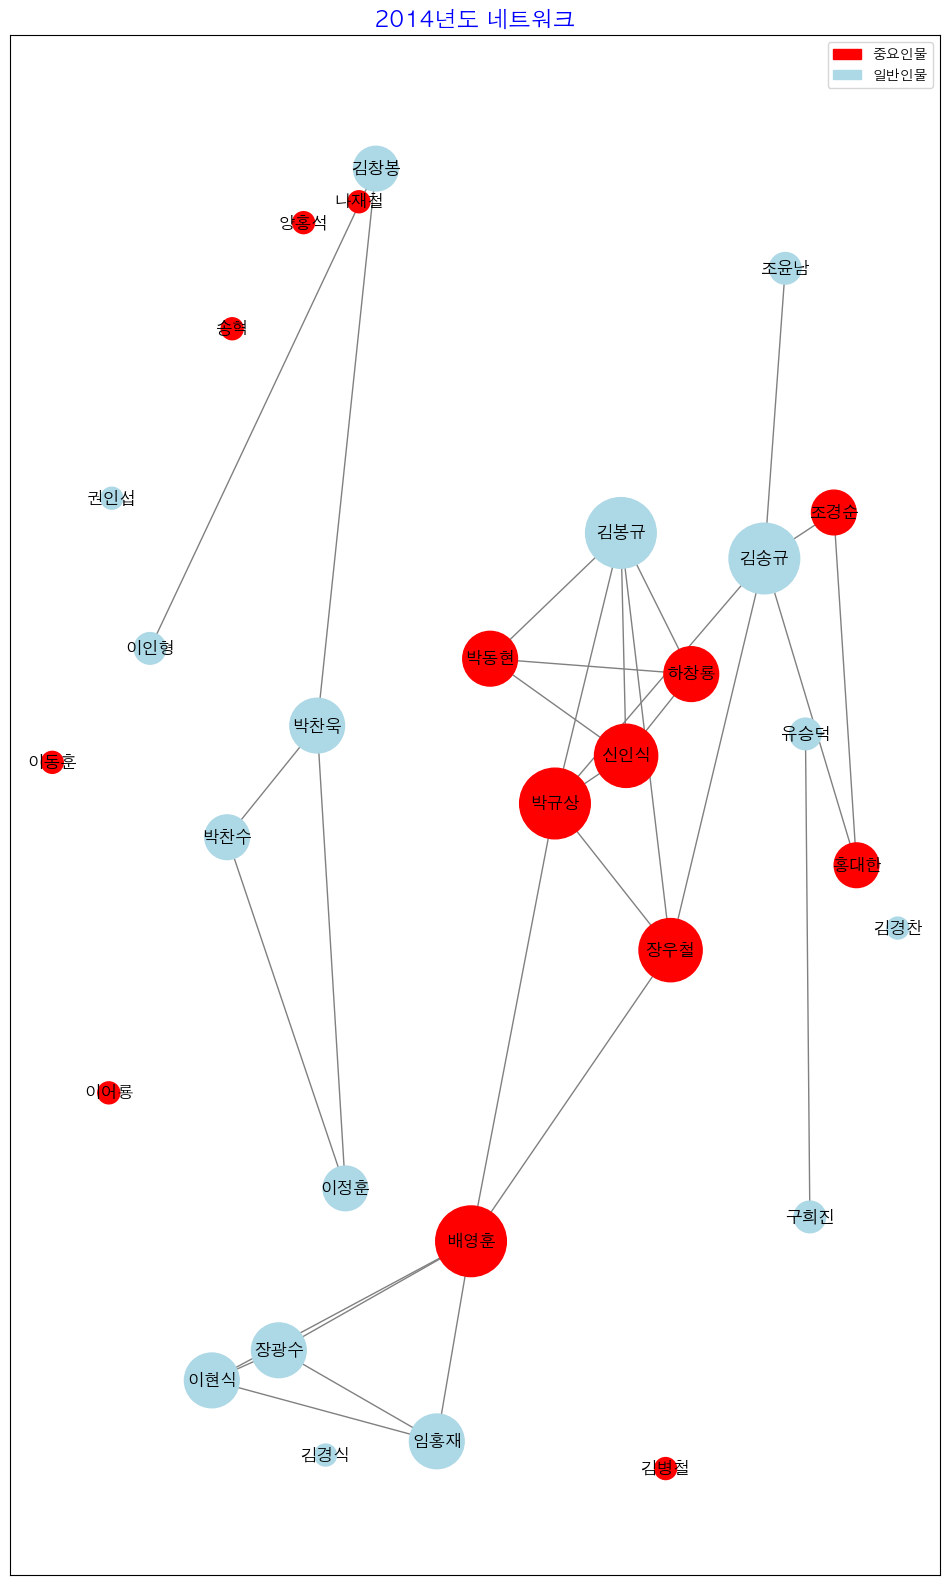

2014년도 네트워크 점수 계산

중요인물 연결 수
김봉규 5
김송규 4
신인식 3
박규상 3
하창룡 2
박동현 2
배영훈 2
장우철 2
이현식 1
홍대한 1
장광수 1
임홍재 1
조경순 1
조윤남 0
나재철 0
이정훈 0
송혁 0
이동훈 0
박찬수 0
구희진 0
유승덕 0
김경식 0
김경찬 0
권인섭 0
이어룡 0
양홍석 0
김병철 0
김창봉 0
박찬욱 0
이인형 0

Degree Centrality:
박규상 0.1724137931034483
김송규 0.1724137931034483
김봉규 0.1724137931034483
배영훈 0.1724137931034483
신인식 0.13793103448275862
장우철 0.13793103448275862
이현식 0.10344827586206896
하창룡 0.10344827586206896
박동현 0.10344827586206896
장광수 0.10344827586206896
임홍재 0.10344827586206896
박찬욱 0.10344827586206896
이정훈 0.06896551724137931
홍대한 0.06896551724137931
박찬수 0.06896551724137931
조경순 0.06896551724137931
김창봉 0.06896551724137931
조윤남 0.034482758620689655
구희진 0.034482758620689655
유승덕 0.034482758620689655
이인형 0.034482758620689655
나재철 0.0
송혁 0.0
이동훈 0.0
김경식 0.0
김경찬 0.0
권인섭 0.0
이어룡 0.0
양홍석 0.0
김병철 0.0

Betweenness Centrality:
김송규 0.07881773399014778
박규상 0.07676518883415437
배영훈 0.07389162561576355
장우철 0.042692939244663386
김봉규 0.034893267651888334
신인식 0.015599343185550077
박찬욱 0.009852216748768473


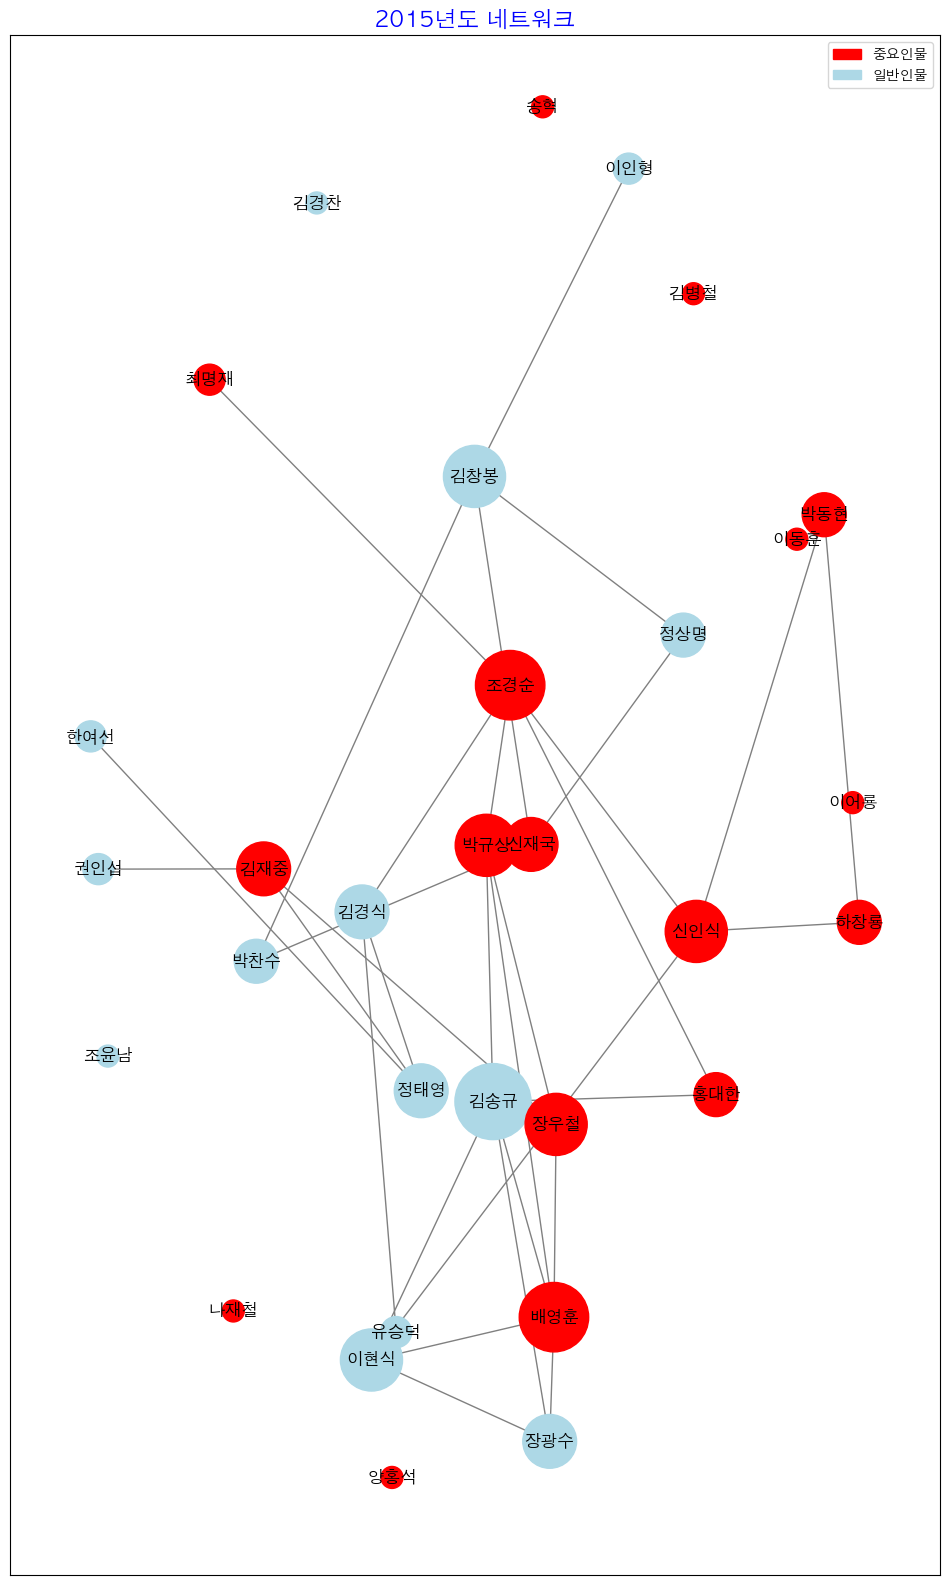

2015년도 네트워크 점수 계산

중요인물 연결 수
김송규 4
조경순 4
박규상 3
장우철 3
신인식 3
하창룡 2
배영훈 2
박동현 2
이현식 2
정상명 1
김창봉 1
김경식 1
홍대한 1
정태영 1
김재중 1
권인섭 1
장광수 1
박찬수 1
최명재 1
김경찬 0
유승덕 0
김병철 0
양홍석 0
나재철 0
조윤남 0
이어룡 0
한여선 0
이동훈 0
신재국 0
송혁 0
이인형 0

Degree Centrality:
김송규 0.2
배영훈 0.16666666666666666
조경순 0.16666666666666666
박규상 0.13333333333333333
김창봉 0.13333333333333333
장우철 0.13333333333333333
신인식 0.13333333333333333
이현식 0.13333333333333333
김경식 0.1
정태영 0.1
신재국 0.1
김재중 0.1
장광수 0.1
정상명 0.06666666666666667
하창룡 0.06666666666666667
홍대한 0.06666666666666667
박동현 0.06666666666666667
박찬수 0.06666666666666667
유승덕 0.03333333333333333
한여선 0.03333333333333333
권인섭 0.03333333333333333
이인형 0.03333333333333333
최명재 0.03333333333333333
김경찬 0.0
김병철 0.0
양홍석 0.0
나재철 0.0
조윤남 0.0
이어룡 0.0
이동훈 0.0
송혁 0.0

Betweenness Centrality:
조경순 0.1268199233716475
신인식 0.08199233716475096
김경식 0.07624521072796936
김재중 0.06283524904214559
장우철 0.06168582375478927
정태영 0.05632183908045977
김송규 0.03831417624521073
박규상 0.03563218390804597
이현식 0.03448275862068966
배영훈 0.0

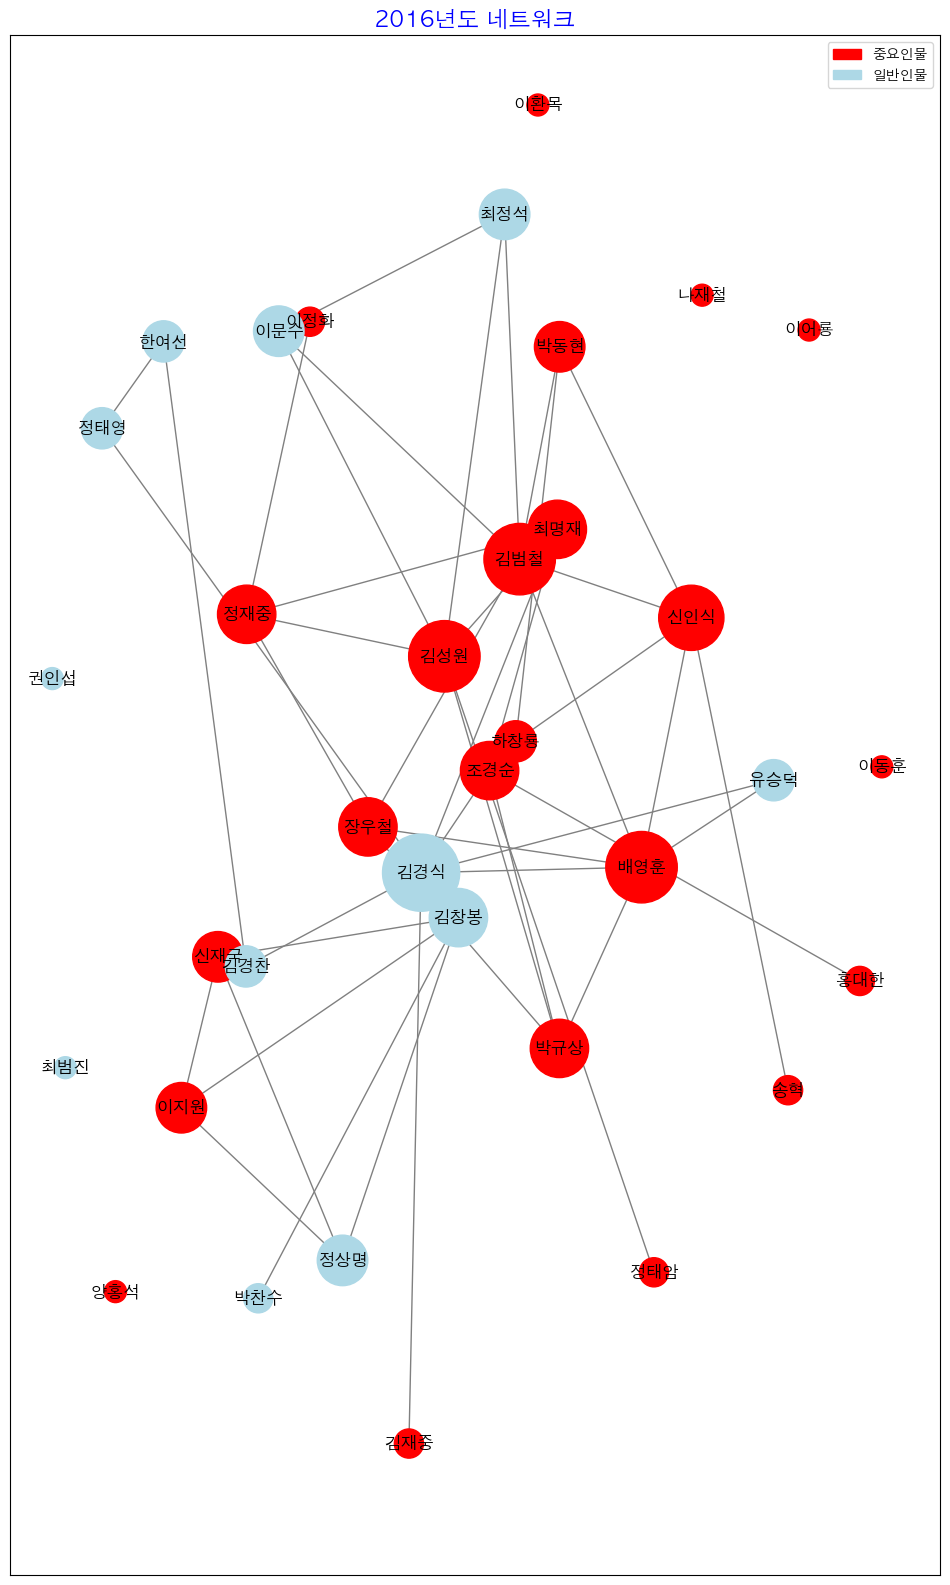

2016년도 네트워크 점수 계산

중요인물 연결 수
신인식 5
장우철 4
박규상 4
김경식 4
김범철 4
김성원 4
정재중 4
배영훈 4
최명재 3
박동현 3
조경순 3
이문수 2
최정석 2
정상명 2
김창봉 2
하창룡 2
송혁 1
이정화 1
신재국 1
정태암 1
홍대한 1
유승덕 1
이지원 1
김재중 0
권인섭 0
이어룡 0
나재철 0
이환목 0
김경찬 0
정태영 0
이동훈 0
박찬수 0
양홍석 0
한여선 0
최범진 0

Degree Centrality:
김경식 0.20588235294117646
김범철 0.1764705882352941
김성원 0.1764705882352941
배영훈 0.1764705882352941
신인식 0.14705882352941177
최명재 0.11764705882352941
장우철 0.11764705882352941
박규상 0.11764705882352941
정재중 0.11764705882352941
조경순 0.11764705882352941
김창봉 0.11764705882352941
신재국 0.08823529411764705
이문수 0.08823529411764705
박동현 0.08823529411764705
최정석 0.08823529411764705
정상명 0.08823529411764705
이지원 0.08823529411764705
김경찬 0.058823529411764705
정태영 0.058823529411764705
유승덕 0.058823529411764705
한여선 0.058823529411764705
하창룡 0.058823529411764705
송혁 0.029411764705882353
이정화 0.029411764705882353
김재중 0.029411764705882353
정태암 0.029411764705882353
홍대한 0.029411764705882353
박찬수 0.029411764705882353
권인섭 0.0
이어룡 0.0
나재철 0.0
이환목 0.0
이동훈 0.0
양홍석 0.0
최범진 0.0

Betwee

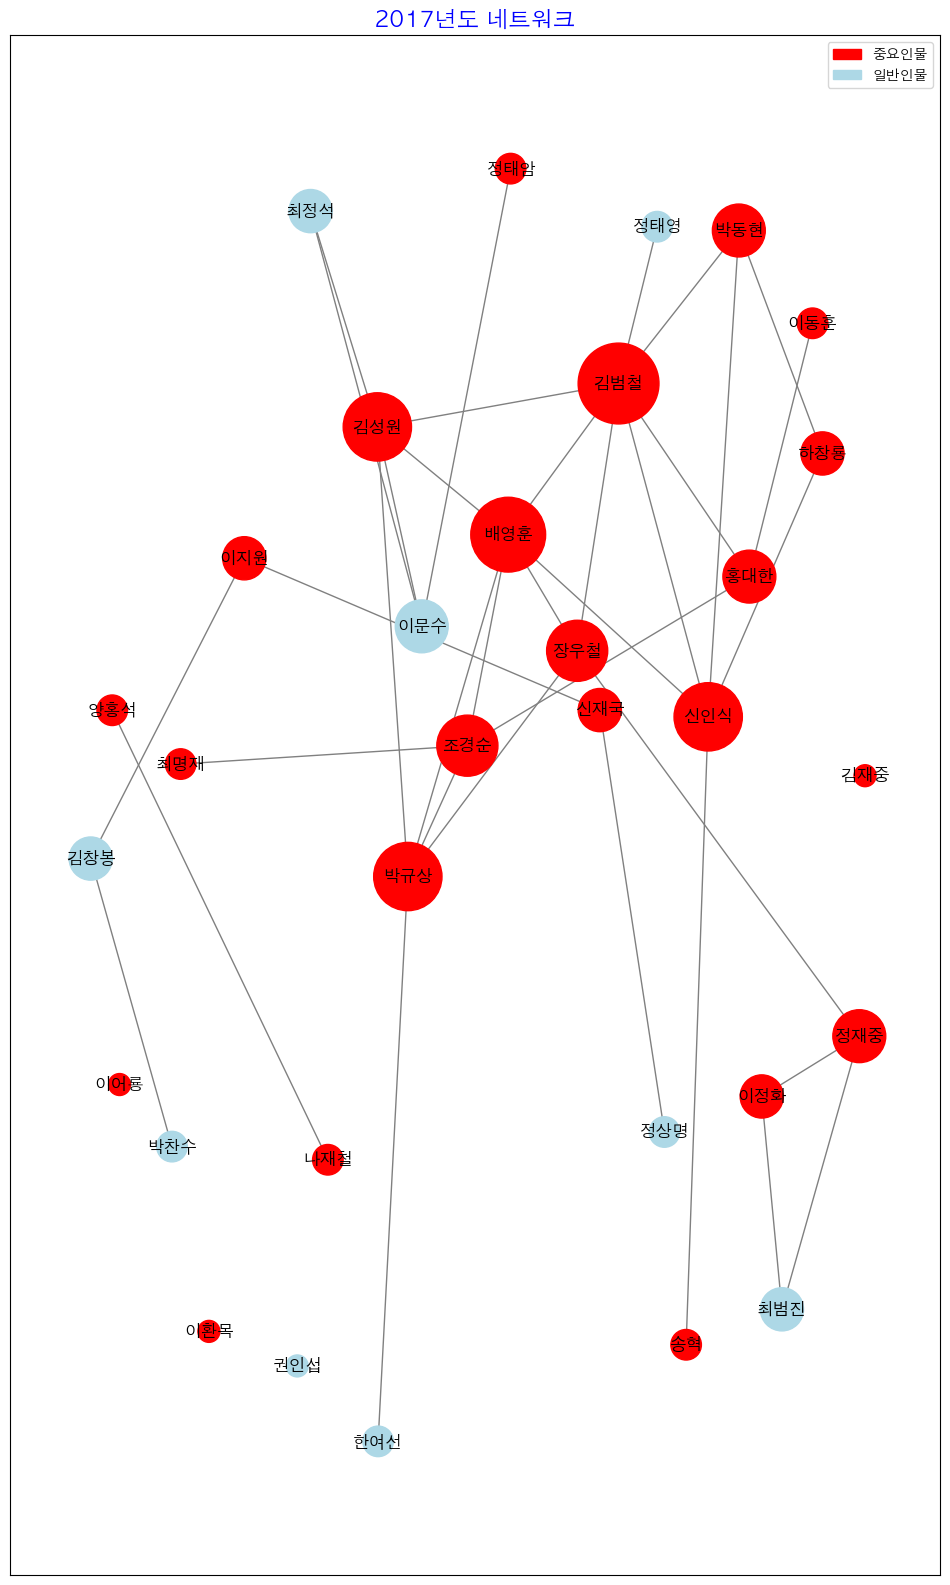

2017년도 네트워크 점수 계산

중요인물 연결 수
김범철 6
배영훈 6
신인식 5
조경순 4
장우철 4
박규상 4
박동현 3
김성원 3
홍대한 3
최범진 2
하창룡 2
이문수 2
정재중 2
정태영 1
김창봉 1
송혁 1
이지원 1
최정석 1
이정화 1
정상명 1
이동훈 1
최명재 1
신재국 1
한여선 1
나재철 1
양홍석 1
이어룡 0
김재중 0
정태암 0
이환목 0
박찬수 0
권인섭 0

Degree Centrality:
김범철 0.22580645161290322
배영훈 0.1935483870967742
김성원 0.16129032258064516
신인식 0.16129032258064516
박규상 0.16129032258064516
조경순 0.12903225806451613
장우철 0.12903225806451613
박동현 0.0967741935483871
이문수 0.0967741935483871
홍대한 0.0967741935483871
정재중 0.0967741935483871
최범진 0.06451612903225806
김창봉 0.06451612903225806
이지원 0.06451612903225806
최정석 0.06451612903225806
이정화 0.06451612903225806
하창룡 0.06451612903225806
신재국 0.06451612903225806
정태영 0.03225806451612903
정태암 0.03225806451612903
송혁 0.03225806451612903
정상명 0.03225806451612903
이동훈 0.03225806451612903
최명재 0.03225806451612903
박찬수 0.03225806451612903
한여선 0.03225806451612903
나재철 0.03225806451612903
양홍석 0.03225806451612903
이어룡 0.0
김재중 0.0
이환목 0.0
권인섭 0.0

Betweenness Centrality:
김범철 0.15913978494623654
장우철 0.1136200

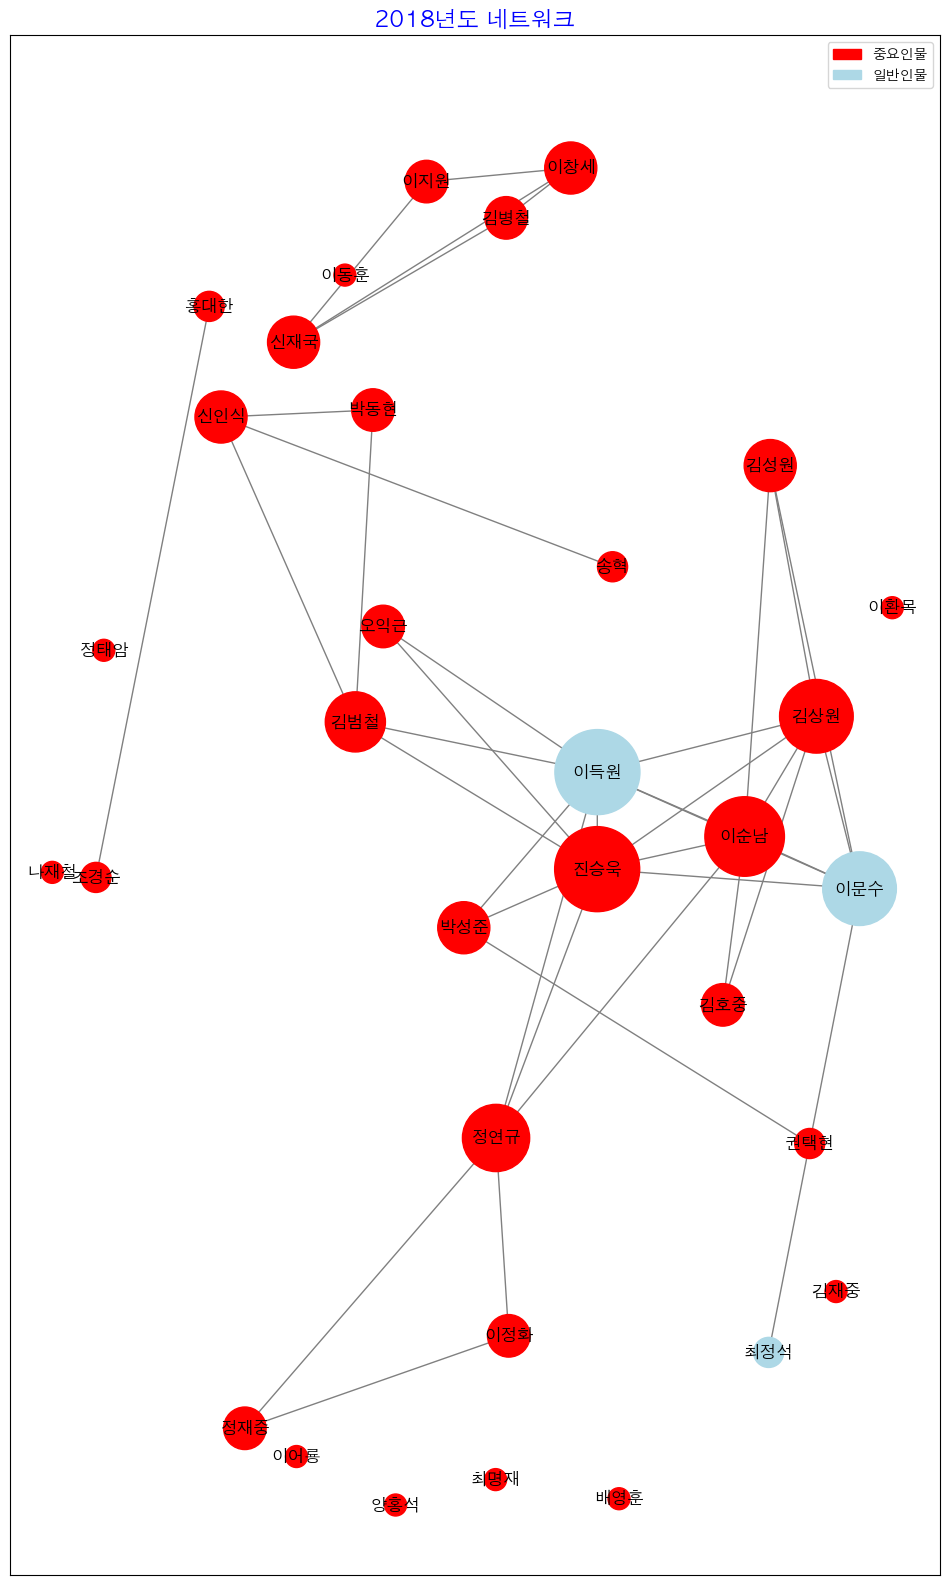

2018년도 네트워크 점수 계산

중요인물 연결 수
이득원 7
진승욱 6
이순남 5
정연규 4
김상원 4
이문수 4
이창세 3
신인식 3
김범철 3
신재국 3
박성준 2
김병철 2
박동현 2
김성원 2
정재중 2
이지원 2
김호중 2
이정화 2
오익근 1
조경순 1
권택현 1
홍대한 1
송혁 1
정태암 0
이환목 0
김재중 0
최정석 0
이어룡 0
배영훈 0
양홍석 0
최명재 0
이동훈 0
나재철 0

Degree Centrality:
진승욱 0.25
이득원 0.25
이순남 0.21875
김상원 0.1875
이문수 0.1875
정연규 0.15625
김범철 0.125
박성준 0.09375
이창세 0.09375
김성원 0.09375
신인식 0.09375
신재국 0.09375
김병철 0.0625
오익근 0.0625
박동현 0.0625
정재중 0.0625
이지원 0.0625
김호중 0.0625
이정화 0.0625
최정석 0.03125
조경순 0.03125
권택현 0.03125
홍대한 0.03125
송혁 0.03125
정태암 0.0
이환목 0.0
김재중 0.0
이어룡 0.0
배영훈 0.0
양홍석 0.0
최명재 0.0
이동훈 0.0
나재철 0.0

Betweenness Centrality:
김범철 0.0846774193548387
진승욱 0.08366935483870967
이득원 0.08366935483870967
정연규 0.06048387096774194
이문수 0.038306451612903226
이순남 0.03629032258064515
박성준 0.03225806451612903
신인식 0.03225806451612903
김상원 0.01814516129032258
이창세 0.0010080645161290322
신재국 0.0010080645161290322
정태암 0.0
이환목 0.0
김재중 0.0
김병철 0.0
오익근 0.0
최정석 0.0
이어룡 0.0
배영훈 0.0
박동현 0.0
조경순 0.0
김성원 0.0
권택현 0.0
홍대한 0.0
정재중 0.0
이지원 0.0

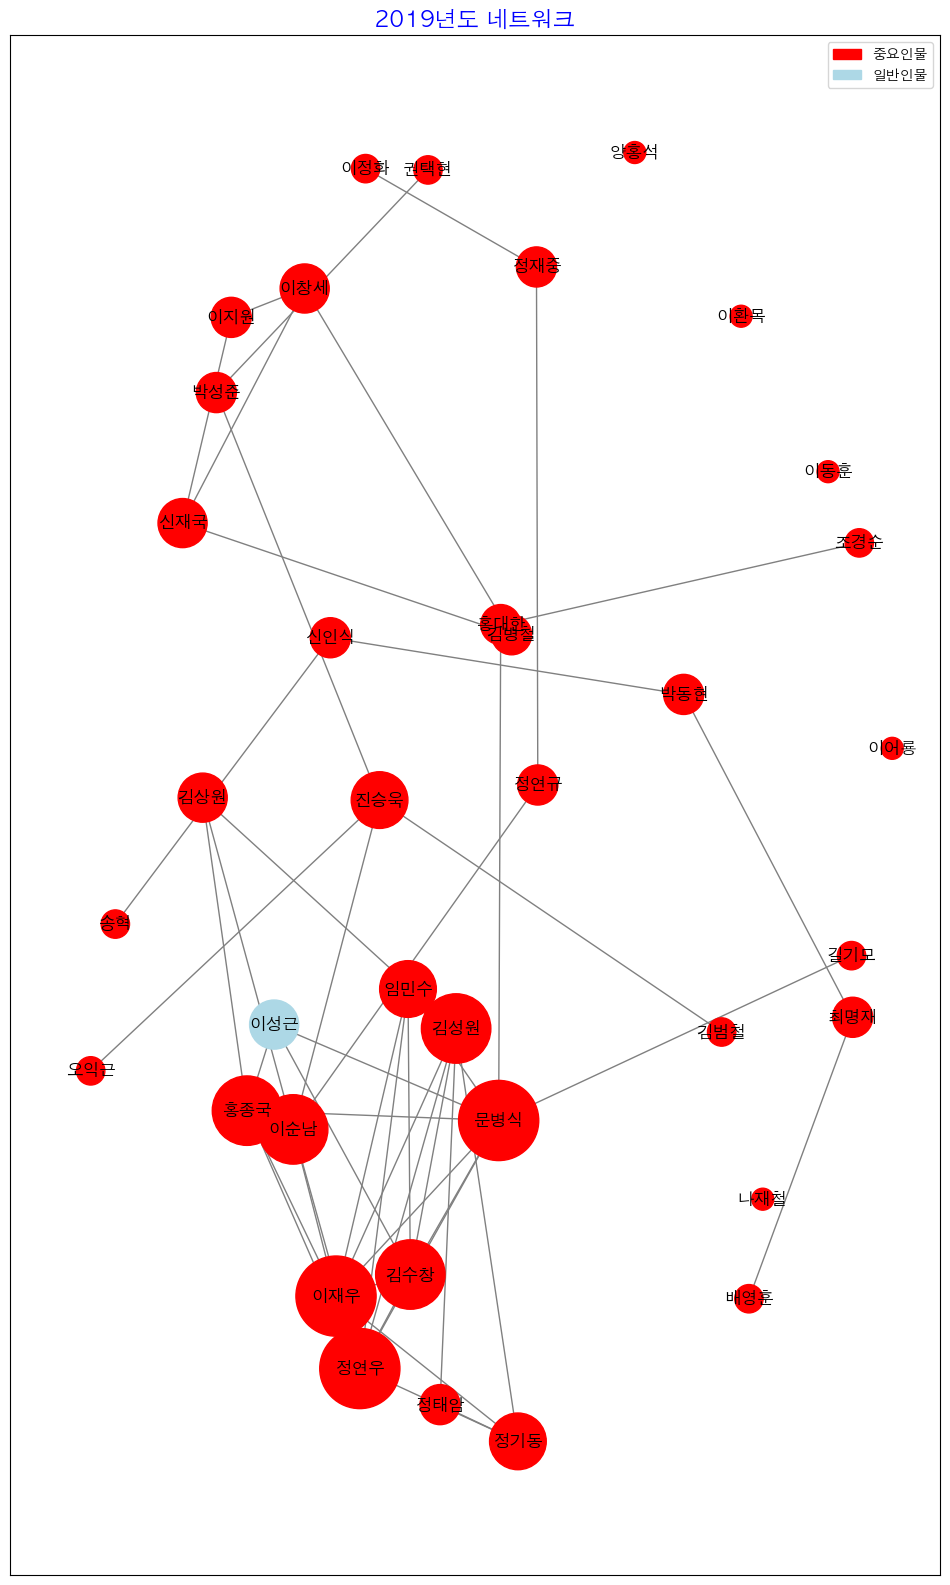

2019년도 네트워크 점수 계산

중요인물 연결 수
이재우 8
정연우 8
문병식 7
김성원 6
이순남 6
홍종국 5
김수창 5
진승욱 4
정기동 4
임민수 4
신재국 3
이창세 3
김상원 3
이성근 3
최명재 2
박동현 2
정태암 2
김병철 2
정재중 2
박성준 2
이지원 2
정연규 2
홍대한 2
신인식 2
권택현 1
조경순 1
배영훈 1
김범철 1
길기모 1
이정화 1
송혁 1
오익근 1
이환목 0
이동훈 0
양홍석 0
이어룡 0
나재철 0

Degree Centrality:
이재우 0.2222222222222222
정연우 0.2222222222222222
문병식 0.2222222222222222
홍종국 0.16666666666666666
김수창 0.16666666666666666
김성원 0.16666666666666666
이순남 0.16666666666666666
진승욱 0.1111111111111111
정기동 0.1111111111111111
임민수 0.1111111111111111
신재국 0.08333333333333333
이창세 0.08333333333333333
김상원 0.08333333333333333
이성근 0.08333333333333333
최명재 0.05555555555555555
박동현 0.05555555555555555
정태암 0.05555555555555555
김병철 0.05555555555555555
정재중 0.05555555555555555
박성준 0.05555555555555555
이지원 0.05555555555555555
정연규 0.05555555555555555
홍대한 0.05555555555555555
신인식 0.05555555555555555
권택현 0.027777777777777776
조경순 0.027777777777777776
배영훈 0.027777777777777776
김범철 0.027777777777777776
길기모 0.027777777777777776
이정화 0.027777777777777776
송혁 0.02777

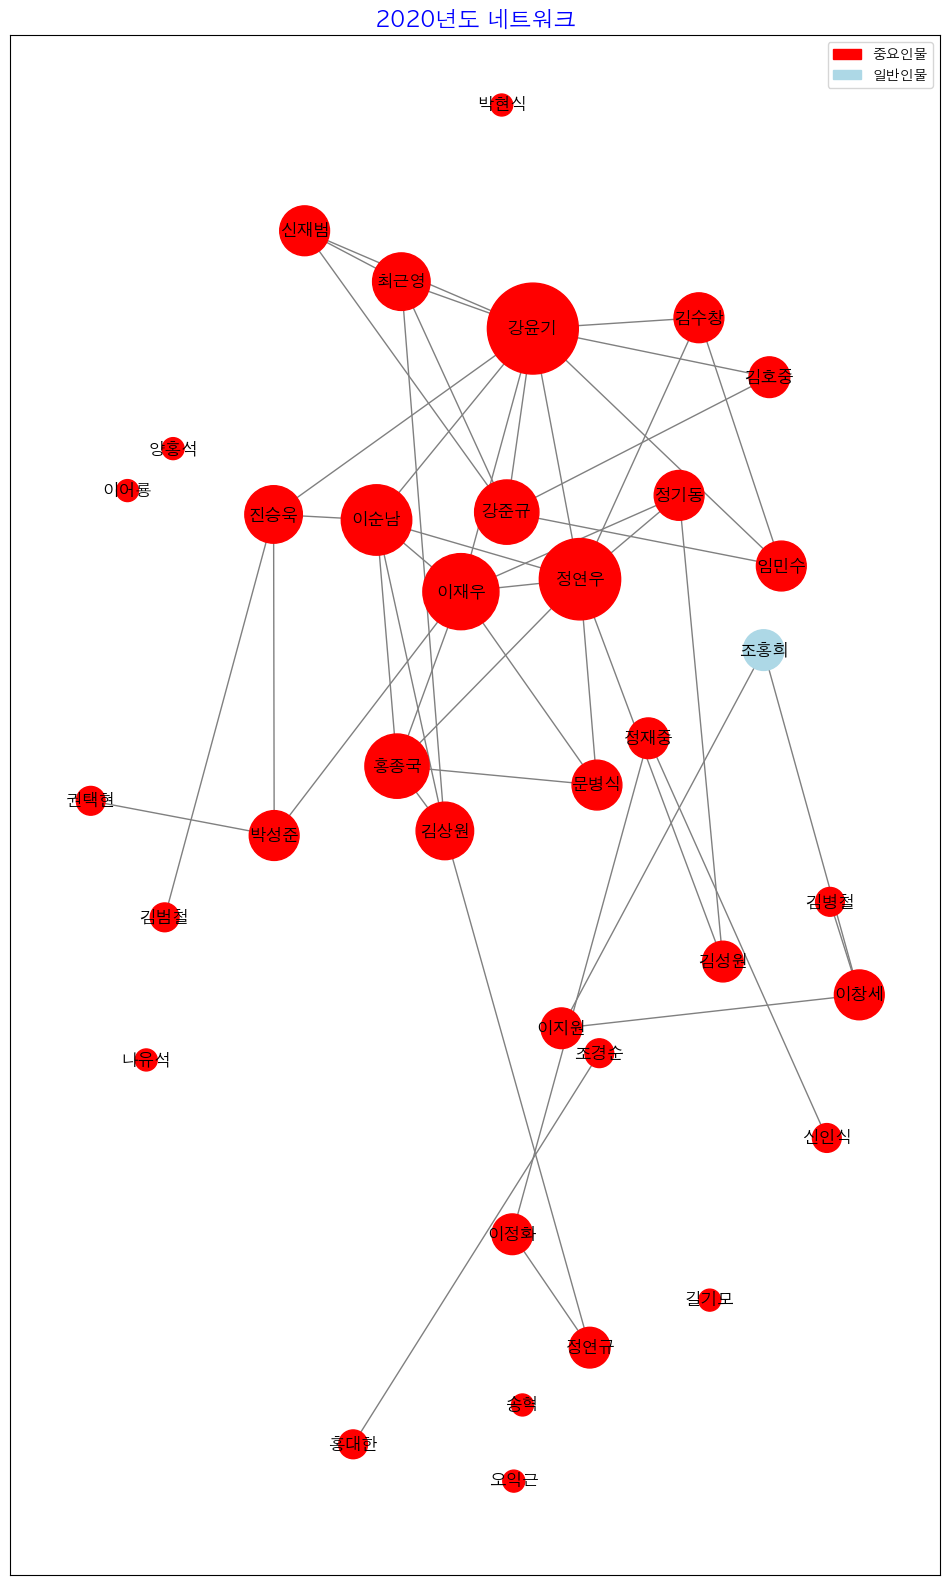

2020년도 네트워크 점수 계산

중요인물 연결 수
강윤기 10
정연우 8
이재우 7
이순남 6
홍종국 5
강준규 5
진승욱 4
김상원 4
최근영 4
박성준 3
임민수 3
정기동 3
김수창 3
신재범 3
문병식 3
이정화 2
정재중 2
김성원 2
정연규 2
김호중 2
이창세 2
조홍희 2
김병철 1
신인식 1
조경순 1
김범철 1
권택현 1
홍대한 1
이지원 1
오익근 0
길기모 0
송혁 0
박현식 0
나유석 0
이어룡 0
양홍석 0

Degree Centrality:
강윤기 0.2857142857142857
정연우 0.22857142857142856
이재우 0.19999999999999998
이순남 0.17142857142857143
홍종국 0.14285714285714285
강준규 0.14285714285714285
진승욱 0.11428571428571428
김상원 0.11428571428571428
최근영 0.11428571428571428
박성준 0.08571428571428572
임민수 0.08571428571428572
정기동 0.08571428571428572
이창세 0.08571428571428572
김수창 0.08571428571428572
신재범 0.08571428571428572
문병식 0.08571428571428572
이정화 0.05714285714285714
정재중 0.05714285714285714
김성원 0.05714285714285714
정연규 0.05714285714285714
김호중 0.05714285714285714
이지원 0.05714285714285714
조홍희 0.05714285714285714
김병철 0.02857142857142857
신인식 0.02857142857142857
조경순 0.02857142857142857
김범철 0.02857142857142857
권택현 0.02857142857142857
홍대한 0.02857142857142857
오익근 0.0
길기모 0.0
송혁 0.0
박현식 0.0
나유석 0.0
이

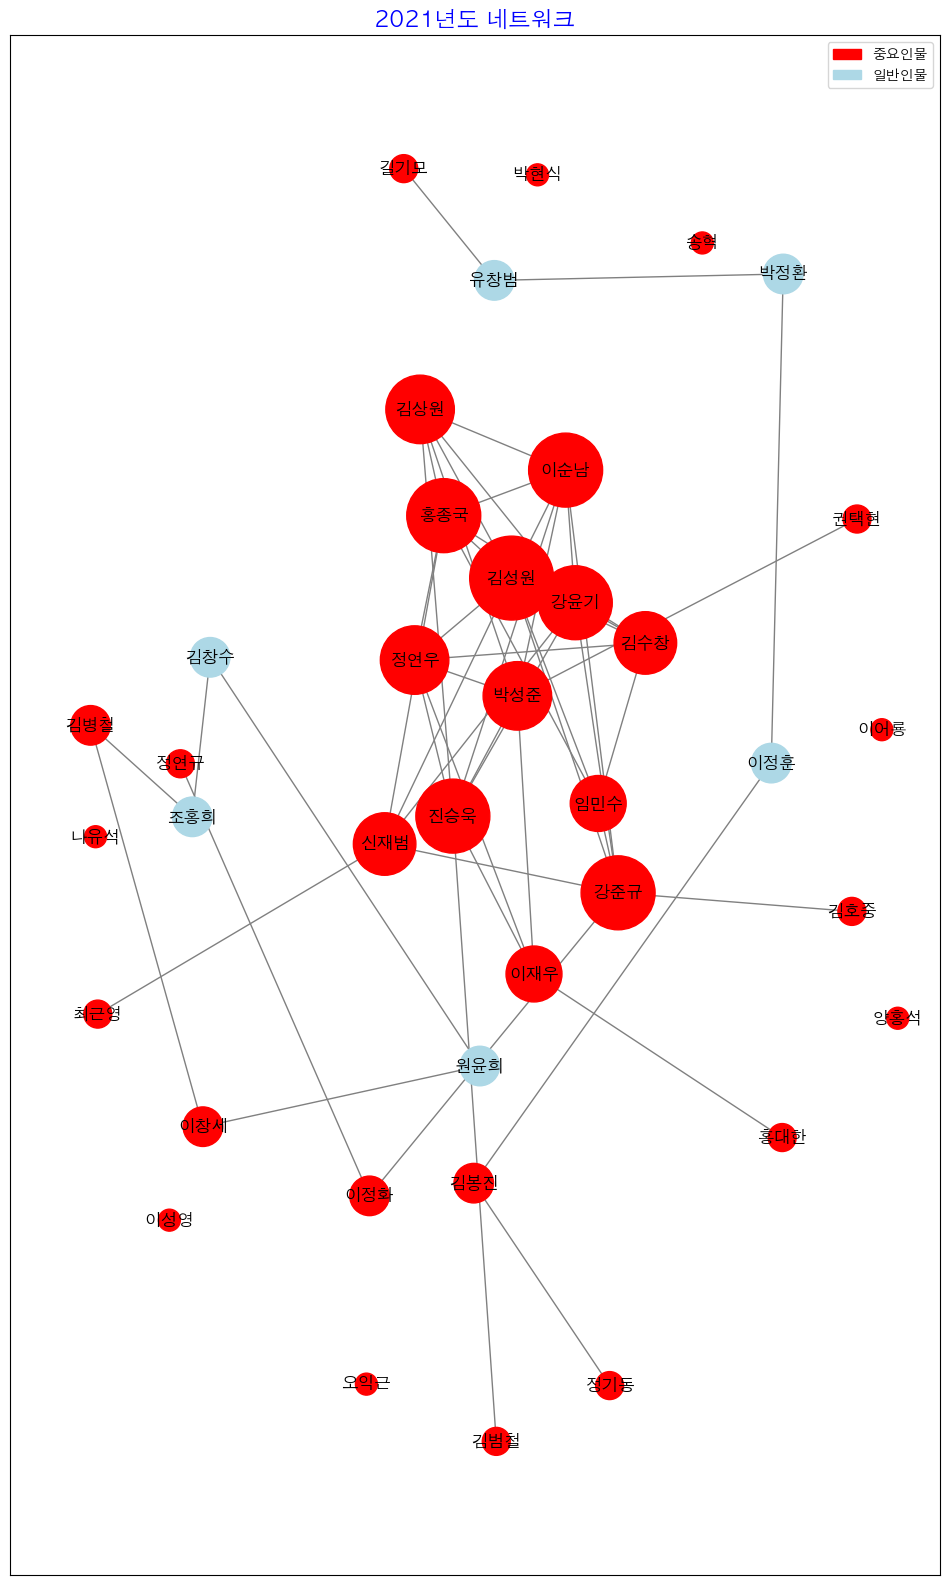

2021년도 네트워크 점수 계산

중요인물 연결 수
김성원 9
강준규 7
진승욱 7
이순남 7
강윤기 7
홍종국 7
정연우 6
김상원 6
박성준 6
신재범 5
김수창 5
이재우 4
임민수 4
이정화 2
김범철 1
김병철 1
원윤희 1
이정훈 1
정기동 1
정연규 1
이창세 1
김봉진 1
최근영 1
조홍희 1
홍대한 1
유창범 1
김호중 1
권택현 1
이어룡 0
양홍석 0
이성영 0
박정환 0
박현식 0
김창수 0
오익근 0
나유석 0
길기모 0
송혁 0

Degree Centrality:
김성원 0.24324324324324326
강준규 0.1891891891891892
진승욱 0.1891891891891892
이순남 0.1891891891891892
강윤기 0.1891891891891892
홍종국 0.1891891891891892
정연우 0.16216216216216217
김상원 0.16216216216216217
박성준 0.16216216216216217
신재범 0.13513513513513514
김수창 0.13513513513513514
이재우 0.10810810810810811
임민수 0.10810810810810811
김병철 0.05405405405405406
원윤희 0.05405405405405406
이정훈 0.05405405405405406
박정환 0.05405405405405406
이창세 0.05405405405405406
이정화 0.05405405405405406
김봉진 0.05405405405405406
조홍희 0.05405405405405406
유창범 0.05405405405405406
김창수 0.05405405405405406
김범철 0.02702702702702703
정기동 0.02702702702702703
정연규 0.02702702702702703
최근영 0.02702702702702703
홍대한 0.02702702702702703
김호중 0.02702702702702703
길기모 0.02702702702702703
권택현 0.027

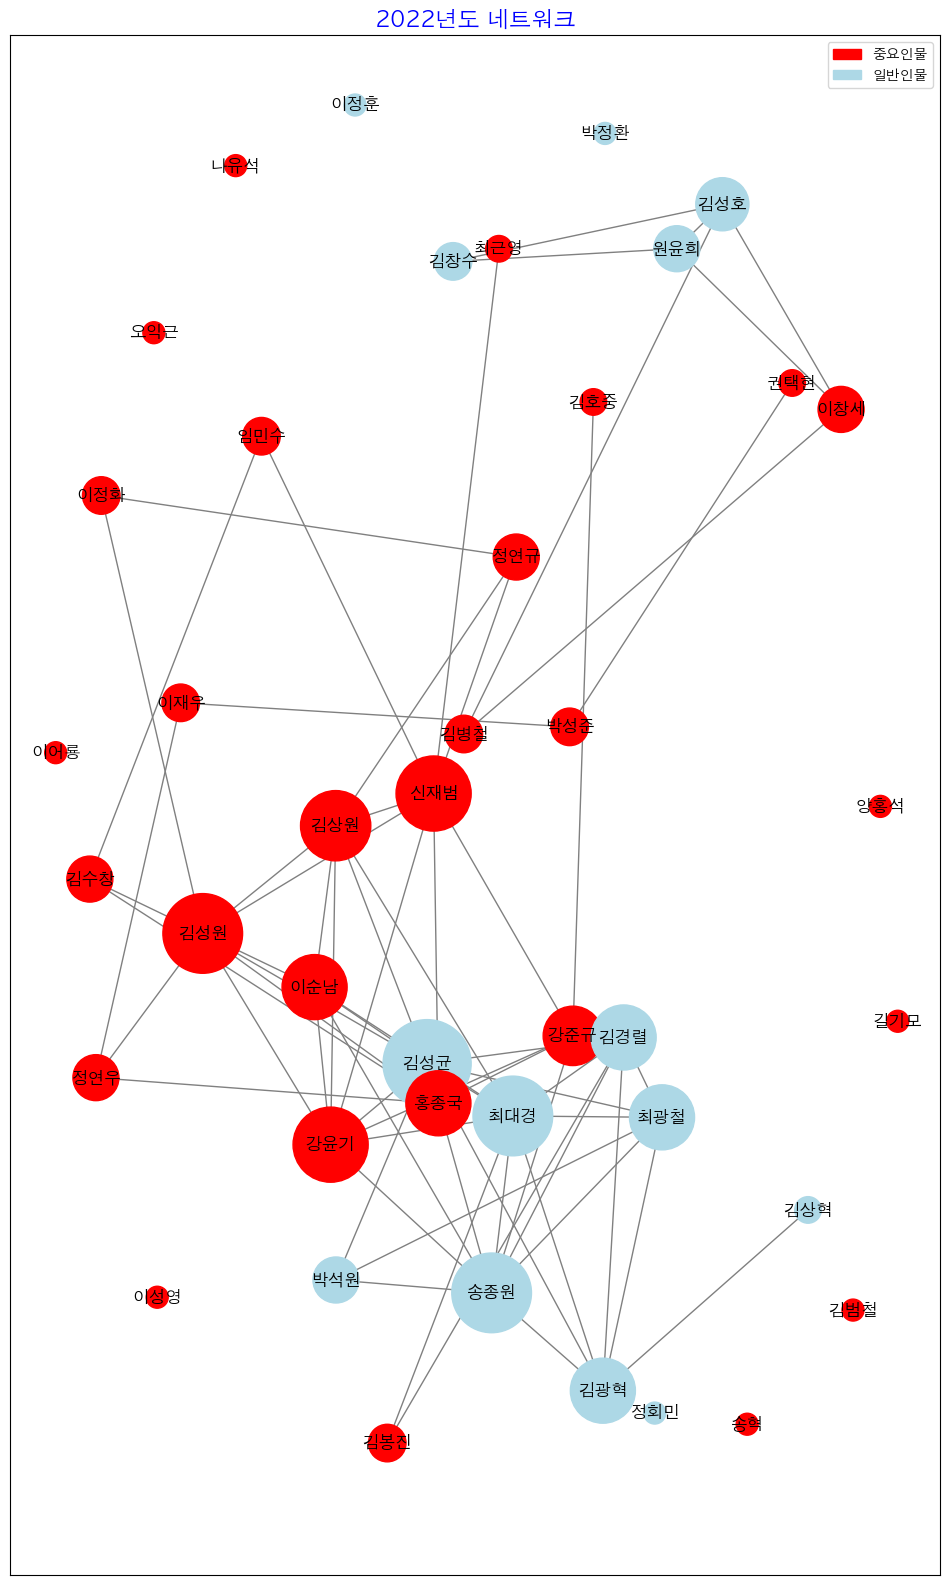

2022년도 네트워크 점수 계산

중요인물 연결 수
김성원 8
신재범 8
김성균 5
홍종국 5
김상원 5
강윤기 5
강준규 4
최대경 4
이순남 3
김수창 3
정연우 3
정연규 3
송종원 3
이정화 2
이재우 2
김성호 2
임민수 2
박성준 2
최근영 1
김병철 1
권택현 1
이창세 1
김경렬 1
원윤희 1
김호중 1
박정환 0
최광철 0
길기모 0
송혁 0
김봉진 0
정회민 0
박석원 0
이정훈 0
오익근 0
이성영 0
김상혁 0
나유석 0
이어룡 0
양홍석 0
김범철 0
김창수 0
김광혁 0

Degree Centrality:
김성균 0.2682926829268293
김성원 0.21951219512195122
최대경 0.21951219512195122
송종원 0.21951219512195122
강윤기 0.1951219512195122
신재범 0.1951219512195122
김상원 0.17073170731707318
이순남 0.14634146341463417
최광철 0.14634146341463417
홍종국 0.14634146341463417
김광혁 0.14634146341463417
김경렬 0.14634146341463417
강준규 0.12195121951219512
김성호 0.0975609756097561
김수창 0.07317073170731708
박석원 0.07317073170731708
정연우 0.07317073170731708
정연규 0.07317073170731708
이창세 0.07317073170731708
원윤희 0.07317073170731708
김병철 0.04878048780487805
이정화 0.04878048780487805
이재우 0.04878048780487805
김봉진 0.04878048780487805
임민수 0.04878048780487805
김창수 0.04878048780487805
박성준 0.04878048780487805
최근영 0.024390243902439025
권택현 0.024390243902439025
김상혁 0.

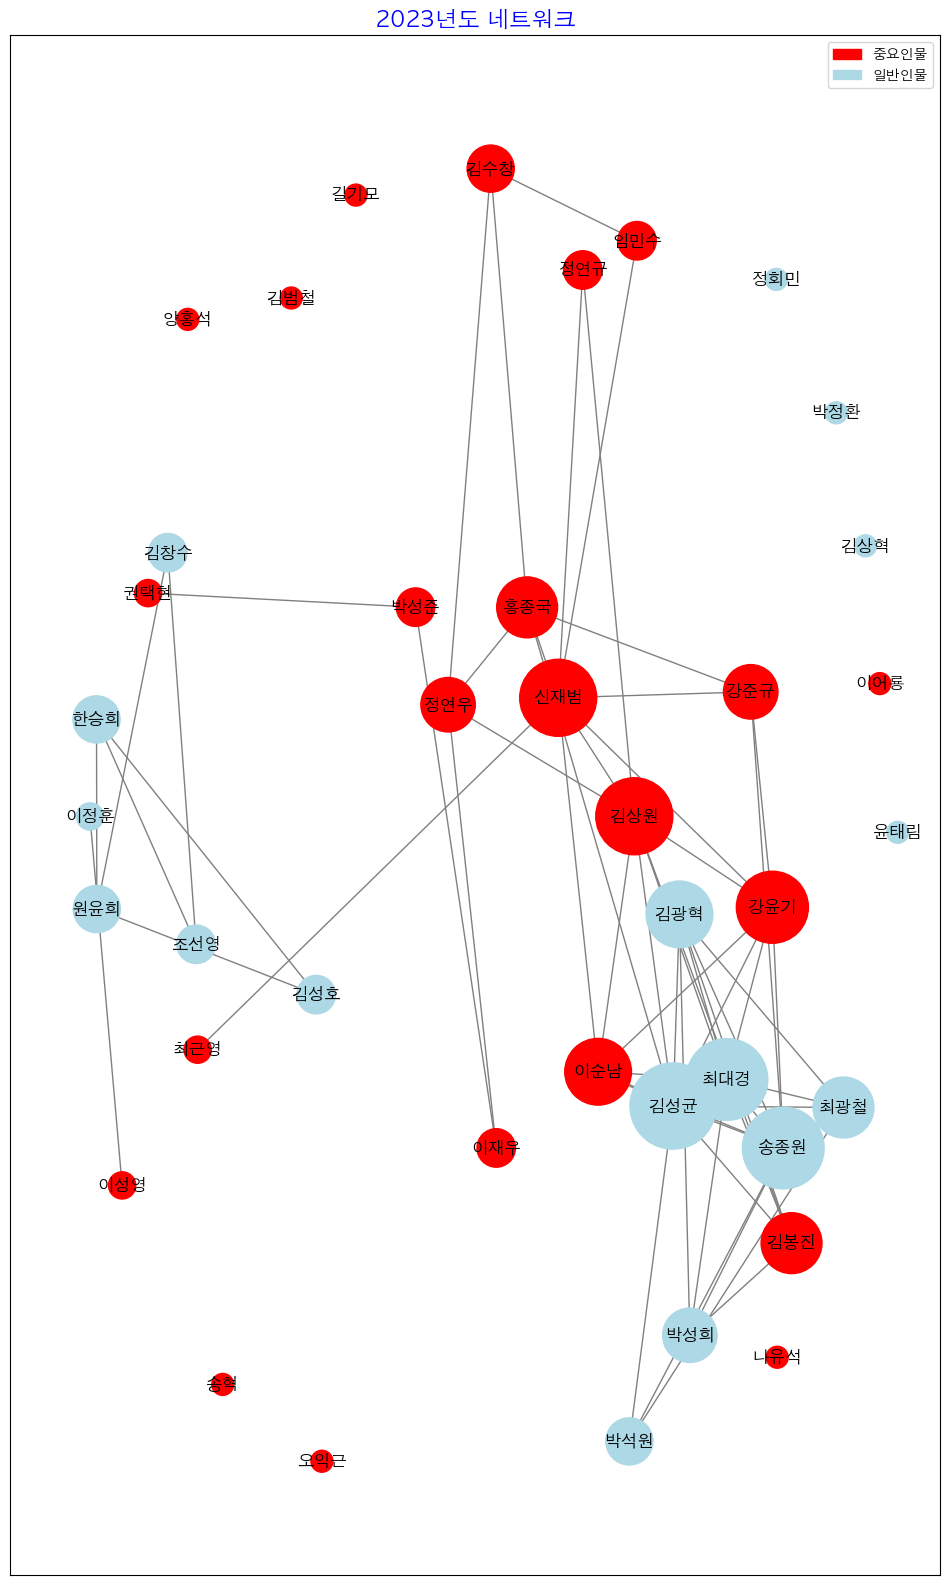

2023년도 네트워크 점수 계산

중요인물 연결 수
신재범 8
김상원 6
김성균 5
강윤기 4
정연우 4
최대경 4
홍종국 4
강준규 3
이순남 3
송종원 3
김수창 3
이재우 2
박성준 2
임민수 2
정연규 2
김봉진 1
최근영 1
권택현 1
박성희 1
김광혁 1
이정훈 1
김성호 0
양홍석 0
정회민 0
박석원 0
박정환 0
송혁 0
김창수 0
최광철 0
김상혁 0
이성영 0
나유석 0
조선영 0
원윤희 0
오익근 0
윤태림 0
이어룡 0
길기모 0
김범철 0
한승희 0

Degree Centrality:
김성균 0.2564102564102564
송종원 0.23076923076923075
최대경 0.23076923076923075
신재범 0.20512820512820512
김상원 0.20512820512820512
강윤기 0.1794871794871795
이순남 0.15384615384615385
김광혁 0.15384615384615385
김봉진 0.1282051282051282
최광철 0.1282051282051282
홍종국 0.1282051282051282
강준규 0.10256410256410256
박성희 0.10256410256410256
정연우 0.10256410256410256
박석원 0.07692307692307693
원윤희 0.07692307692307693
김수창 0.07692307692307693
한승희 0.07692307692307693
김성호 0.05128205128205128
김창수 0.05128205128205128
이재우 0.05128205128205128
박성준 0.05128205128205128
조선영 0.05128205128205128
임민수 0.05128205128205128
정연규 0.05128205128205128
최근영 0.02564102564102564
권택현 0.02564102564102564
이성영 0.02564102564102564
이정훈 0.02564102564102564
양홍석 0.0
정회민 0.0
박정환 0

In [14]:
result_dict_all_year = print_network(matrixs)

In [19]:
#weights 값 임의로 설정
def weighted_average_values(result_dict, weights = [3.5, 2.5, 1.5, 1.5, 1], rank = 5):
    # 각 키에 해당하는 값들을 가중 평균하여 하나의 값으로 계산
    weighted_values = []
    for values in result_dict.values():
        weighted_value = sum(value * weight for value, weight in zip(values, weights))
        weighted_values.append(weighted_value)
            
    weighted_dict = {}
    keys = list(result_dict.keys())
    for i, key in enumerate(keys):
        weighted_dict[key] = weighted_values[i]

    sorted_items = sorted(weighted_dict.items(), key=lambda x: x[1], reverse=True)
    top_values = sorted_items[:rank]
    top_dict = {key: value for key, value in top_values}

    bottom_values = sorted_items[-rank:]
    bottom_dict = {key: value for key, value in bottom_values}

    for key in top_dict:
        top_dict[key] *= 100

    for key in bottom_dict:
        bottom_dict[key] *= 100
    
    return top_dict, bottom_dict


weights = [3.5, 2.5, 1.5, 1.5, 1]
for year in YEAR_LIST:
    print("-----------------------",year,"--------------------------")
       # 속성별 가중치 값
    top_dict, bottom_dict = weighted_average_values(result_dict_all_year[year], weights)  
    print(top_dict)    
     
    print(bottom_dict)

----------------------- 2014 --------------------------
{'김봉규': 879.58393340052, '김송규': 861.7643674958231, '박규상': 856.09375, '배영훈': 727.3629942399243, '장우철': 648.3935502702005}
{'나재철': 0.0, '송혁': 0.0, '양홍석': 0.0, '이동훈': 0.0, '이어룡': 0.0}
----------------------- 2015 --------------------------
{'조경순': 898.3852582149603, '김송규': 879.5277468595963, '장우철': 700.2277906133819, '신인식': 685.999202171405, '박규상': 683.5657050489125}
{'송혁': 0.0, '양홍석': 0.0, '이동훈': 0.0, '이어룡': 0.0, '조윤남': 0.0}
----------------------- 2016 --------------------------
{'김경식': 896.8147860138238, '배영훈': 861.7861740981109, '김범철': 780.5874816686854, '신인식': 780.3145707560997, '김성원': 756.7184020962569}
{'양홍석': 0.0, '이동훈': 0.0, '이어룡': 0.0, '이환목': 0.0, '최범진': 0.0}
----------------------- 2017 --------------------------
{'김범철': 995.9372367930945, '배영훈': 898.7451737451737, '신인식': 724.1771961903863, '박규상': 682.5457669623256, '장우철': 679.9947563299822}
{'박찬수': 58.51435996547656, '권인섭': 0.0, '김재중': 0.0, '이어룡': 0.0, '이환목': 0.0}
-------